In [3]:
import cv2
import numpy as np
import json
from tqdm import tqdm
import os


In [ ]:
# Diccionario de mapeo de etiquetas
mapa_etiquetas = {
    "Huevo": 1,
    "Platano": 2,
    "Chile": 3,
    "papa": 4
}

# Lista de archivos
Entrenamiento = [
    "Entrenamiento1", "Entrenamiento2", "Entrenamiento3", "Entrenamiento4"#,
   # "Prueba1", "Prueba2", "Prueba3"
]


Pruebas = [

    "Prueba1", "Prueba2", "Prueba3"
]

ruta_base = "/Users/Leon/Documents/Data GH/Vision Computación/Clasificador bayesiano/Comida/"

X = []
y = []

In [23]:
def generar_mascara_etiquetada(img_shape, objetos, etiqueta_map):
    mask = np.zeros(img_shape[:2], dtype=np.uint8)
    for obj in objetos:
        label = obj['label']
        puntos = np.array(obj['points'], dtype=np.int32) 
        etiqueta = etiqueta_map.get(label, 0)
        cv2.fillPoly(mask, [puntos], etiqueta)
    return mask

def extraer_caracteristicas(nombres):
    
    X = []
    y = []

    for nombre in tqdm(nombres):
        ruta_imagen = os.path.join(ruta_base, f"{nombre}.jpg")
        ruta_json = os.path.join(ruta_base, f"{nombre}.json")

        img = cv2.imread(ruta_imagen)
        with open(ruta_json, "r") as f:
            data = json.load(f)

        objetos = data['shapes']
        mask = generar_mascara_etiquetada(img.shape, objetos, mapa_etiquetas)

        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
        img_hs = img_hsv[:, :, :2]
        img_hs3 = np.concatenate([img_hs, np.zeros((img_hs.shape[0], img_hs.shape[1], 1), dtype=np.uint8)], axis=2)

        pixels = img_hs3.reshape(-1, 3)
        etiquetas = mask.flatten()

        X.append(pixels)
        y.append(etiquetas)

    return np.vstack(X), np.hstack(y)


In [26]:
# Convertir a matrices finales
X_train, y_train = extraer_caracteristicas(Entrenamiento)

print("✅ Extracción completa")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("Clases encontradas:", np.unique(y_train))

100%|██████████| 4/4 [00:00<00:00, 47.82it/s]

✅ Extracción completa
X_train shape: (1440000, 3)
y_train shape: (1440000,)
Clases encontradas: [0 1 2 3]


In [27]:

X_test, y_test= extraer_caracteristicas(Pruebas)

print("✅ Extracción completa")
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("Clases encontradas:", np.unique(y_test))

100%|██████████| 3/3 [00:00<00:00, 48.41it/s]

✅ Extracción completa
X_test shape: (1080000, 3)
y_test shape: (1080000,)
Clases encontradas: [0 1 2 3 4]


In [30]:

from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))

Number of mislabeled points out of a total 1080000 points : 38902


Accuracy: 0.9639796296296296
Precision (macro): 0.7061051682010302


/Users/Leon/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Recall (macro): 0.7615784843807194
F1-score (macro): 0.732250344989025


/Users/Leon/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/Leon/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/Leon/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Reporte completo:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99    833079
           1       0.90      0.98      0.94     69254
           2       0.88      0.96      0.92    112439
           3       0.76      0.88      0.81     45013
           4       0.00      0.00      0.00     20215

    accuracy                           0.96   1080000
   macro avg       0.71      0.76      0.73   1080000
weighted avg       0.95      0.96      0.96   1080000



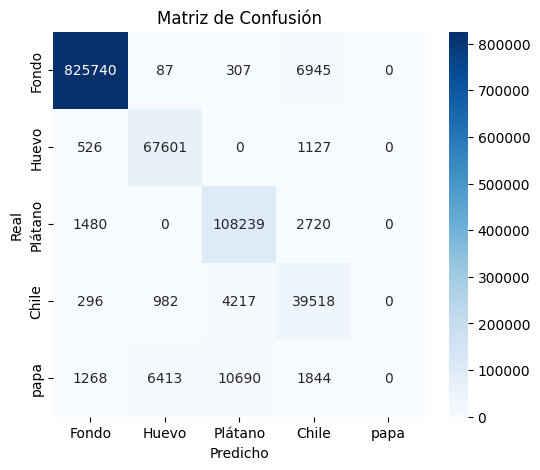

In [31]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc


#from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns




# === MÉTRICAS CLÁSICAS ===
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision (macro):", precision_score(y_test, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred, average='macro'))
print("F1-score (macro):", f1_score(y_test, y_pred, average='macro'))

# Reporte detallado
print("\nReporte completo:\n", classification_report(y_test, y_pred))

# === MATRIZ DE CONFUSIÓN ===
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Fondo", "Huevo", "Plátano", "Chile","papa"],
            yticklabels=["Fondo", "Huevo", "Plátano", "Chile","papa"])
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

In [41]:

# Lista de archivos (ajusta a tus nombres reales)
Test = [
    "Prueba3"
]

X_val, y_val = extraer_caracteristicas(Test)

print("Clases encontradas:", np.unique(y_val))
y_pred_val = gnb.predict(X_val)
    

100%|██████████| 1/1 [00:00<00:00, 40.54it/s]

Clases encontradas: [0 1 2 3 4]


In [42]:
from PIL import Image

# Abre la imagen
imagen = Image.open(os.path.join(ruta_base, Test[0]+".jpg"))

# Obtiene las dimensiones
ancho, alto = imagen.size

print(f"Ancho: {ancho} px, Alto: {alto} px")

Ancho: 600 px, Alto: 600 px


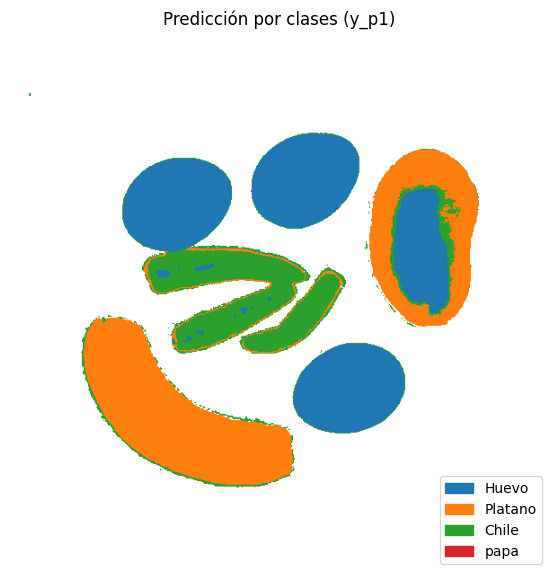

In [43]:

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


# Crear mapa de colores (RGB en 0-255)
colormap = plt.get_cmap('tab10')
clase_a_color = {
    valor: (np.array(colormap(i))[:3] * 255).astype(np.uint8)
    for i, valor in enumerate(mapa_etiquetas.values())
}

# Fondo blanco por defecto
mask = y_pred_val.reshape(600, 600)
predicted_image = np.ones((600, 600, 3), dtype=np.uint8) * 255  # fondo blanco

# Pintar clases con sus colores
for clase, color in clase_a_color.items():
    predicted_image[mask == clase] = color

# Mostrar imagen
plt.figure(figsize=(7, 7))
plt.imshow(predicted_image)
plt.title("Predicción por clases (y_p1)")
plt.axis("off")

# Crear leyenda
leyenda = [
    mpatches.Patch(color=np.array(clase_a_color[val]) / 255.0, label=nombre)
    for nombre, val in mapa_etiquetas.items()
]

plt.legend(handles=leyenda, loc="lower right")
plt.show()


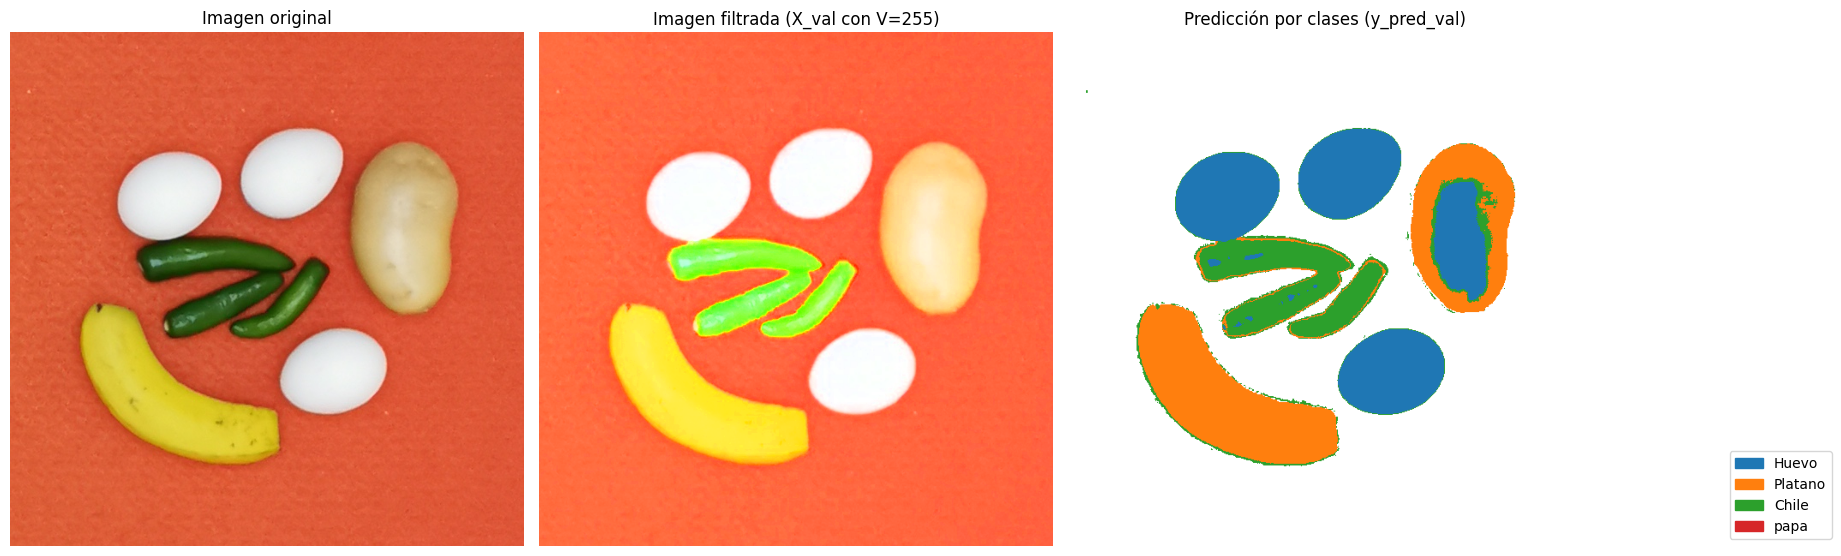

In [48]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from PIL import Image
import numpy as np
import os
import cv2



# Cargar imagen original
imagen = Image.open(os.path.join(ruta_base, Test[0] + ".jpg"))
img_original = np.array(imagen)

# Reconstruir imagen filtrada desde X_val (HS + V=0 originalmente)
img_filtrada = X_val.reshape(600, 600, 3).astype(np.uint8)

# Sustituir canal V con brillo máximo (255)
img_filtrada[:, :, 2] = 255

# Convertir de HSV a RGB para visualización
img_filtrada_rgb = cv2.cvtColor(img_filtrada, cv2.COLOR_HSV2RGB)

# Crear máscara clasificada
mask = y_pred_val.reshape(600, 600)

# Crear mapa de colores
colormap = plt.get_cmap('tab10')
clase_a_color = {
    valor: (np.array(colormap(i))[:3] * 255).astype(np.uint8)
    for i, valor in enumerate(mapa_etiquetas.values())
}

# Imagen de predicción con fondo blanco
predicted_image = np.ones((600, 600, 3), dtype=np.uint8) * 255
for clase, color in clase_a_color.items():
    predicted_image[mask == clase] = color

# Mostrar las tres imágenes
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].imshow(img_original)
axs[0].set_title("Imagen original")
axs[0].axis("off")

axs[1].imshow(img_filtrada_rgb)
axs[1].set_title("Imagen filtrada (X_val con V=255)")
axs[1].axis("off")

axs[2].imshow(predicted_image)
axs[2].set_title("Predicción por clases (y_pred_val)")
axs[2].axis("off")

# Leyenda
leyenda = [
    mpatches.Patch(color=np.array(clase_a_color[val]) / 255.0, label=nombre)
    for nombre, val in mapa_etiquetas.items()
]

plt.legend(handles=leyenda, loc="lower right", bbox_to_anchor=(1.5, 0))
plt.tight_layout()
plt.show()

